In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import umap


In [ ]:
#read in similarity matracies (/Users/harsh/Downloads/PFP_existing_BP_similarity_matrix.tsv)
PFP_existing_BP_sim_matrix = pd.read_csv('resnik_BP_similarity_matrix_NEW_2.tsv', sep='\t', index_col=0)
PFP_existing_MF_sim_matrix = pd.read_csv('resnik_MF_similarity_matrix_NEW_2.tsv', sep='\t', index_col=0)
PFP_existing_CC_sim_matrix = pd.read_csv('resnik_CC_similarity_matrix_NEW_2.tsv', sep='\t', index_col=0)

In [ ]:
existing_path = 'existing_terms_NEW_2.txt'
new_path = 'new_pfp_terms_NEW_2.txt'
combined_path = 'combined_existing_pfp_NEW_2.txt'
matrices = {
    'BP': PFP_existing_BP_sim_matrix,
    'MF': PFP_existing_MF_sim_matrix,
    'CC': PFP_existing_CC_sim_matrix,
}

In [ ]:
def load_term_sets(existing_path, new_path):
    existing = set(pd.read_csv(existing_path, header=None)[0])
    new_only = set(pd.read_csv(new_path,   header=None)[0])
    return existing, new_only

def sanitize_to_distance(sim_df: pd.DataFrame) -> np.ndarray:
    """Convert a similarity matrix to a valid precomputed distance matrix."""
    sim = sim_df.values.astype(float)

    # If similarities aren't in [0,1], rescale to [0,1] per-matrix
    s_min, s_max = np.nanmin(sim), np.nanmax(sim)
    if not (0.0 <= s_min and s_max <= 1.0):
        if s_max > s_min:  # avoid division by zero
            sim = (sim - s_min) / (s_max - s_min)
        else:
            sim = np.zeros_like(sim)

    # Convert to distances
    dist = 1.0 - sim

    # Force symmetry and zero diagonal; clip negatives due to rounding
    dist = 0.5 * (dist + dist.T)
    np.fill_diagonal(dist, 0.0)
    dist = np.clip(dist, 0.0, None)

    # Replace NaNs / infs if any
    dist[~np.isfinite(dist)] = 0.0
    return dist

def compute_embeddings(matrices, existing, new_only, random_state=42):
    """
    matrices: dict str→DataFrame of term×term similarities
    existing, new_only: sets of GO IDs
    returns: dict onto→(emb, labels, terms)
    """
    results = {}
    for onto, sim in matrices.items():
        terms  = sim.index.tolist()
        # Make labels precise and avoid mislabeling terms not in either set
        labels = [
            'Existing' if t in existing else
            'PFP predicted' if t in new_only else
            'Other'
            for t in terms
        ]

        dist = sanitize_to_distance(sim)

        reducer = umap.UMAP(metric='precomputed', random_state=random_state)
        emb     = reducer.fit_transform(dist)

        results[onto] = (emb, labels, terms)
    return results

existing, new_only = load_term_sets(existing_path, new_path)
embeddings_dict    = compute_embeddings(matrices, existing, new_only)


In [ ]:
with open('go_umap_embeddings.pkl', 'wb') as f:
  pickle.dump(embeddings_dict, f)

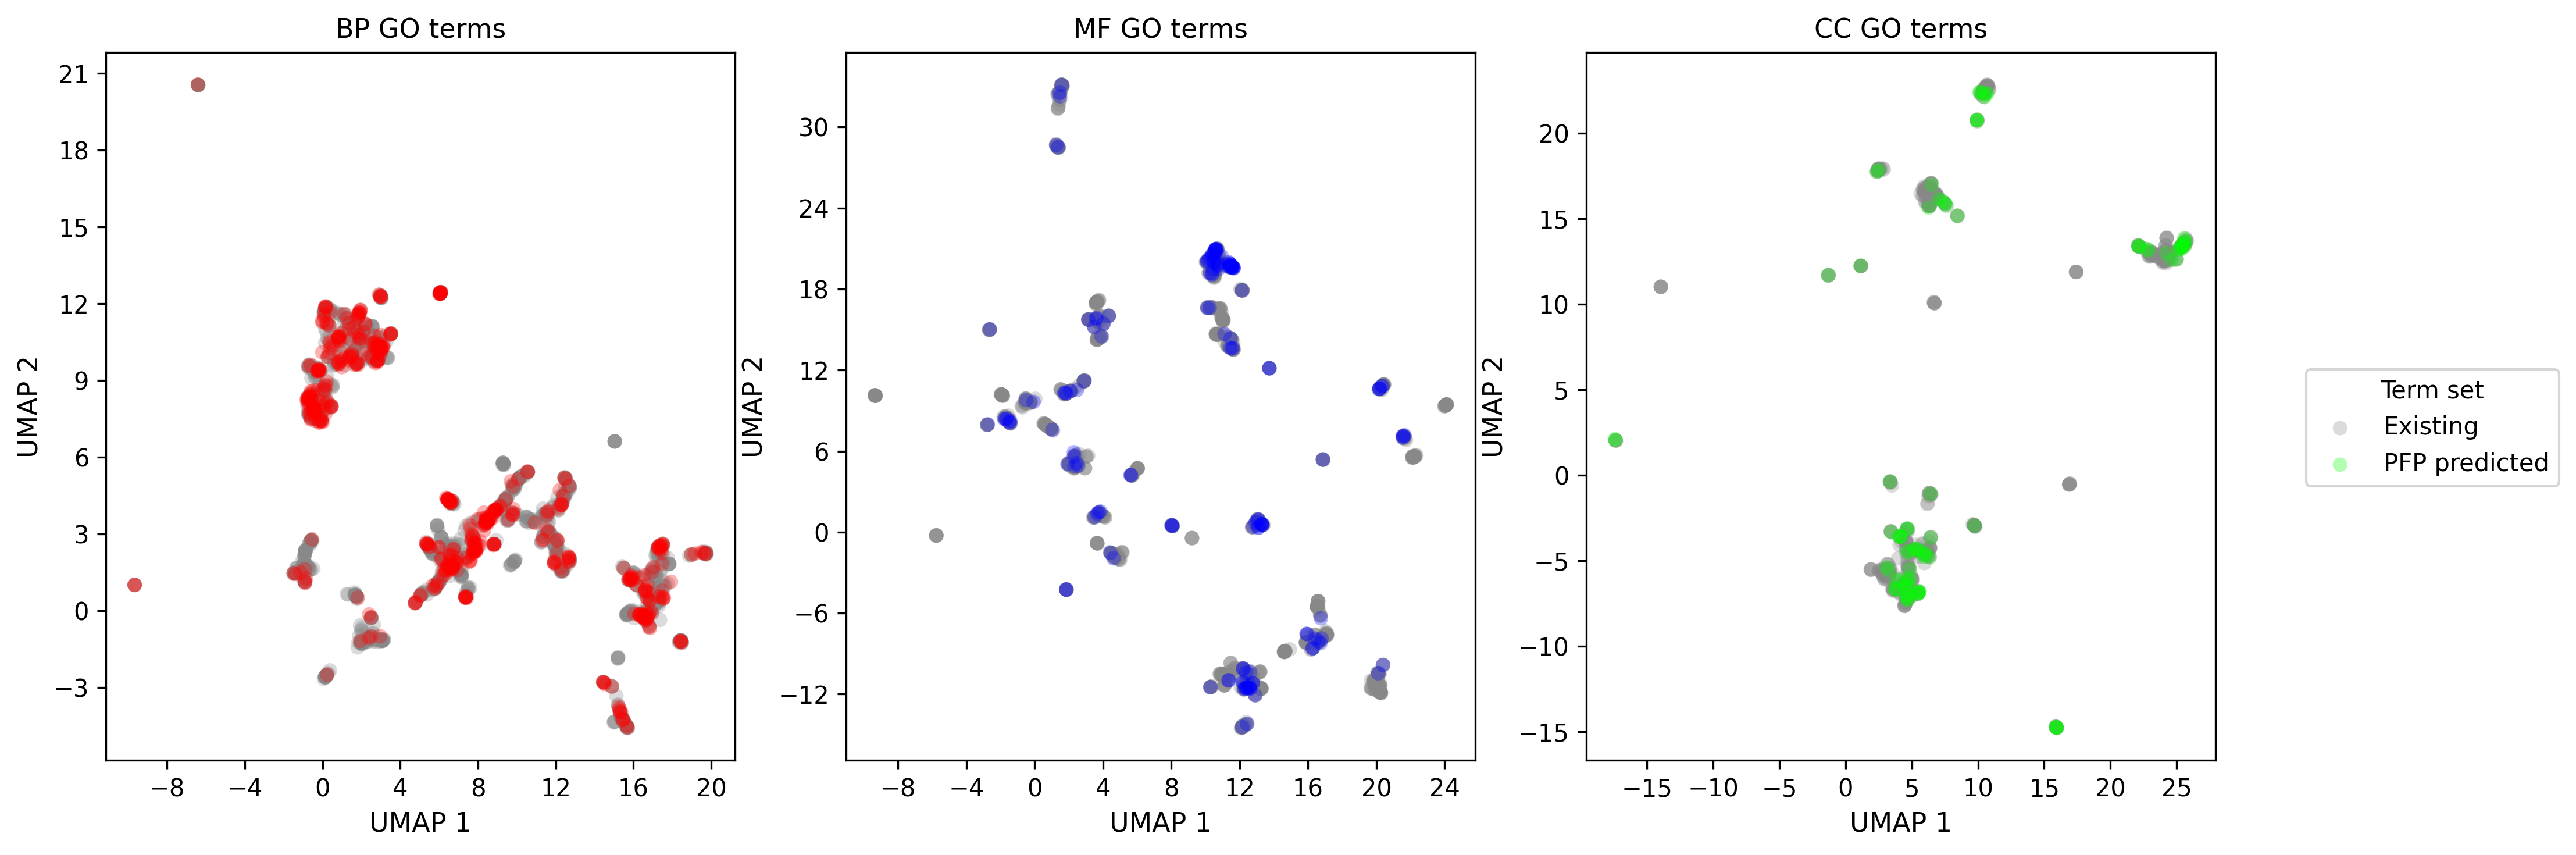

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

PFP_COLORS = {
    'BP': '#FF0000',  # red
    'MF': '#0000FF',  # blue
    'CC': '#00FF00',  # green
}

EXISTING_COLOR = '#888888'  # mid‐grey for all existing points

def plot_go_umap(embeddings_dict, figsize=(15,5), dpi=300):
    fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=dpi)

    for ax, (onto, (emb, labels, terms)) in zip(axes, embeddings_dict.items()):
        for lbl in ['Existing', 'PFP predicted']:
            if lbl == 'Existing':
                c = EXISTING_COLOR
            else:
                c = PFP_COLORS.get(onto, '#000000')

            # get indices for this label
            idx = [i for i, l in enumerate(labels) if l == lbl]
            ax.scatter(
                emb[idx,0], emb[idx,1],
                label=lbl,
                c=c,
                alpha=0.3,
                edgecolors='none'
            )

        ax.set_title(f"{onto} GO terms",fontsize = 11)
        ax.set_xlabel('UMAP 1',fontsize = 11)
        ax.set_ylabel('UMAP 2',fontsize = 11)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))


    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        title='Term set',
        loc='center left',
        bbox_to_anchor=(0.88, 0.5)
    )

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.show()


if __name__ == "__main__":
    # load precomputed embeddings
    with open('go_umap_embeddings.pkl','rb') as f:
        embeddings_dict = pickle.load(f)

    plot_go_umap(embeddings_dict)


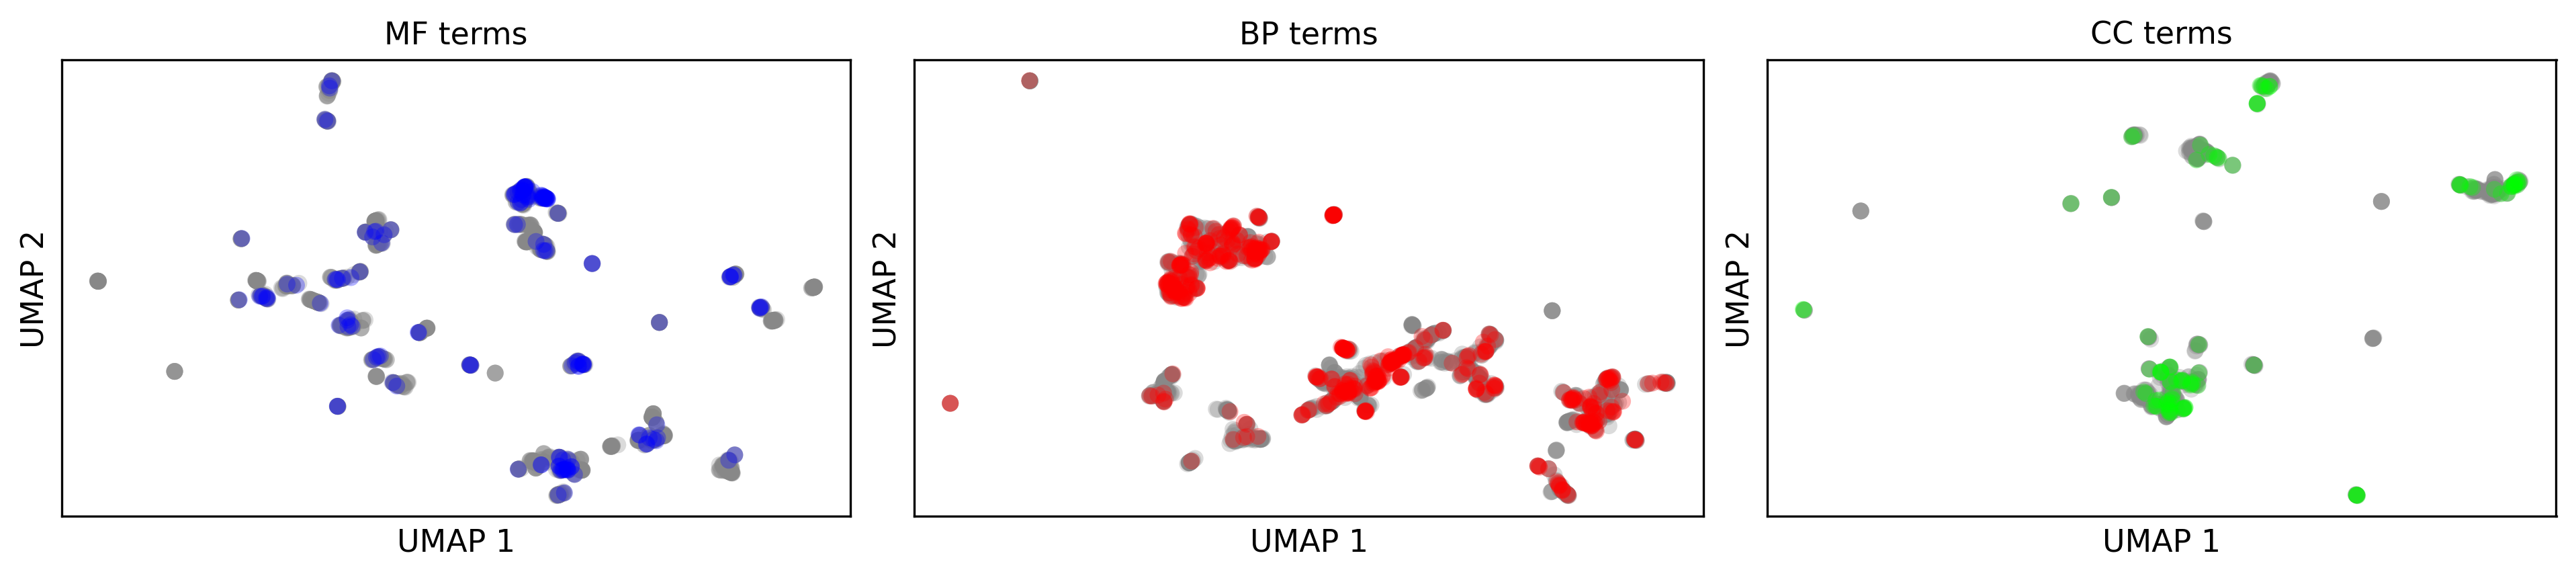

In [ ]:
import matplotlib as mpl
mpl.rcParams.update({
    'font.size':            11,
    'axes.titlesize':       11,
    'axes.labelsize':       11,
    'xtick.labelsize':      11,
    'ytick.labelsize':      11,
    'legend.fontsize':      11,
    'legend.title_fontsize':11,
    'figure.titlesize':     11,
})

PFP_COLORS = {
    'BP': '#FF0000',  # red
    'MF': '#0000FF',  # blue
    'CC': '#00FF00',  # green
}

EXISTING_COLOR = '#888888'  

ONTO_ORDER = ['MF', 'BP', 'CC']

def plot_go_umap(embeddings_dict, figsize=(15,3), dpi=300):
    fig, axes = plt.subplots(1, len(ONTO_ORDER), figsize=figsize, dpi=dpi)


    for ax, onto in zip(axes, ONTO_ORDER):
        emb, labels, terms = embeddings_dict[onto]
        for lbl in ['Existing', 'PFP predicted']:

            c = EXISTING_COLOR if lbl == 'Existing' else PFP_COLORS.get(onto, '#000000')


            idx = [i for i, l in enumerate(labels) if l == lbl]
            ax.scatter(
                emb[idx,0], emb[idx,1],
                label=lbl,
                c=c,
                alpha=0.3,
                edgecolors='none'
            )

        ax.set_title(f"{onto} terms")
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        # hide the tick marks and labels
        ax.set_xticks([])
        ax.set_yticks([])

    # shared legend on the right
    # handles, labels = axes[-1].get_legend_handles_labels()
    # fig.legend(
    #     handles, labels,
    #     title='Term set',
    #     loc='center left',
    #     bbox_to_anchor=(0.88, 0.5)
    # )

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.savefig('go_umap.png', dpi=dpi)
    plt.show()


if __name__ == "__main__":
    with open('go_umap_embeddings.pkl','rb') as f:
        embeddings_dict = pickle.load(f)

    plot_go_umap(embeddings_dict)


In [ ]:
def save_embeddings_to_csv(embeddings_dict, out_csv="go_umap_embeddings.csv"):
    rows = []
    for onto, (emb, labels, terms) in embeddings_dict.items():
        for i in range(len(labels)):
            rows.append({
                "Ontology": onto,
                "UMAP1": emb[i, 0],
                "UMAP2": emb[i, 1],
                "Label": labels[i],
                "Term": terms[i]
            })
    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    print(f"Saved {len(df)} rows to {out_csv}")
save_embeddings_to_csv(embeddings_dict, "go_umap_embeddings.csv")


Saved 4014 rows to go_umap_embeddings.csv


# cluster

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud


def cluster_and_wordcloud(sim_matrices, obo_file="go-basic.obo", k_min=2, k_max=10):
    """
    For each ontology in sim_matrices (dict of name → similarity DataFrame):
    1) Determines optimal k by silhouette score over range [k_min, k_max]
    """
    term_names = {}
    with open(obo_file) as f:
        current_id = None
        for line in f:
            line = line.strip()
            if line == "[Term]":
                current_id = None
            elif line.startswith("id: GO:"):
                current_id = line.split("id: ")[1]
            elif line.startswith("name: ") and current_id:
                term_names[current_id] = line.split("name: ")[1]

    for onto, sim in sim_matrices.items():
        terms = sim.index.tolist()
        X = sim.values

        ks = list(range(k_min, k_max + 1))
        sil_scores = []
        for k in ks:
            labels = KMeans(n_clusters=k, random_state=42).fit_predict(X)
            sil_scores.append(silhouette_score(X, labels))
        best_k = ks[int(np.argmax(sil_scores))]
        print(f"{onto}: Optimal k = {best_k}")

        plt.figure(figsize=(5,3))
        plt.plot(ks, sil_scores, marker='o')
        plt.title(f"{onto} Silhouette Scores")
        plt.xlabel("k")
        plt.ylabel("Silhouette")
        plt.show()

        
sim_matrices = {
    'BP': PFP_existing_BP_sim_matrix,
    'MF': PFP_existing_MF_sim_matrix,
    'CC': PFP_existing_CC_sim_matrix
}
cluster_and_wordcloud(sim_matrices)


In [ ]:


def cluster_and_wordcloud(sim_matrices, obo_file="go-basic.obo", k_min=2, k_max=10, k_overrides=None):
    """
    """
    k_overrides = k_overrides or {}

    term_names = {}
    with open(obo_file) as f:
        current_id = None
        for line in f:
            line = line.strip()
            if line == "[Term]":
                current_id = None
            elif line.startswith("id: GO:"):
                current_id = line.split("id: ")[1]
            elif line.startswith("name: ") and current_id:
                term_names[current_id] = line.split("name: ")[1]

    for onto, sim in sim_matrices.items():
        terms = sim.index.tolist()
        X = sim.values

        if onto in k_overrides:
            best_k = int(k_overrides[onto])
            print(f"{onto}: Using overridden k = {best_k}")
            sil_scores = None
        else:
            ks = list(range(k_min, k_max + 1))
            sil_scores = []
            for k in ks:
                labels = KMeans(n_clusters=k, random_state=42, n_init="auto").fit_predict(X)
                sil_scores.append(silhouette_score(X, labels))
            best_k = ks[int(np.argmax(sil_scores))]
            print(f"{onto}: Optimal k = {best_k}")

            plt.figure(figsize=(3,3), dpi=300)
            plt.plot(ks, sil_scores, marker='o')
            plt.title(f"{onto} Silhouette Scores")
            plt.xlabel("k")
            plt.ylabel("Silhouette")
            plt.show()

        final_labels = KMeans(n_clusters=best_k, random_state=42, n_init="auto").fit_predict(X)
        df = pd.DataFrame({'GO_ID': terms, 'Cluster': final_labels})
        df.to_csv(f'{onto}_term_clusters.tsv', sep='\t', index=False)

        for cluster_id in sorted(set(final_labels)):
            cluster_terms = df[df['Cluster'] == cluster_id]['GO_ID']
            names = [term_names.get(t, "") for t in cluster_terms]
            text = " ".join(names)
            wc = WordCloud(width=400, height=200, background_color='white').generate(text)
            plt.figure(figsize=(2,2), dpi=300)
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"{onto} Cluster {cluster_id}")
            plt.show()


# Example usage:
sim_matrices = {
    'BP': PFP_existing_BP_sim_matrix,
    'MF': PFP_existing_MF_sim_matrix,
    'CC': PFP_existing_CC_sim_matrix
}

cluster_and_wordcloud(
    sim_matrices,
    k_min=2,
    k_max=10,
    k_overrides={'CC': 4, 'MF': 7, 'BP': 8}
)



BP: Using overridden k = 8


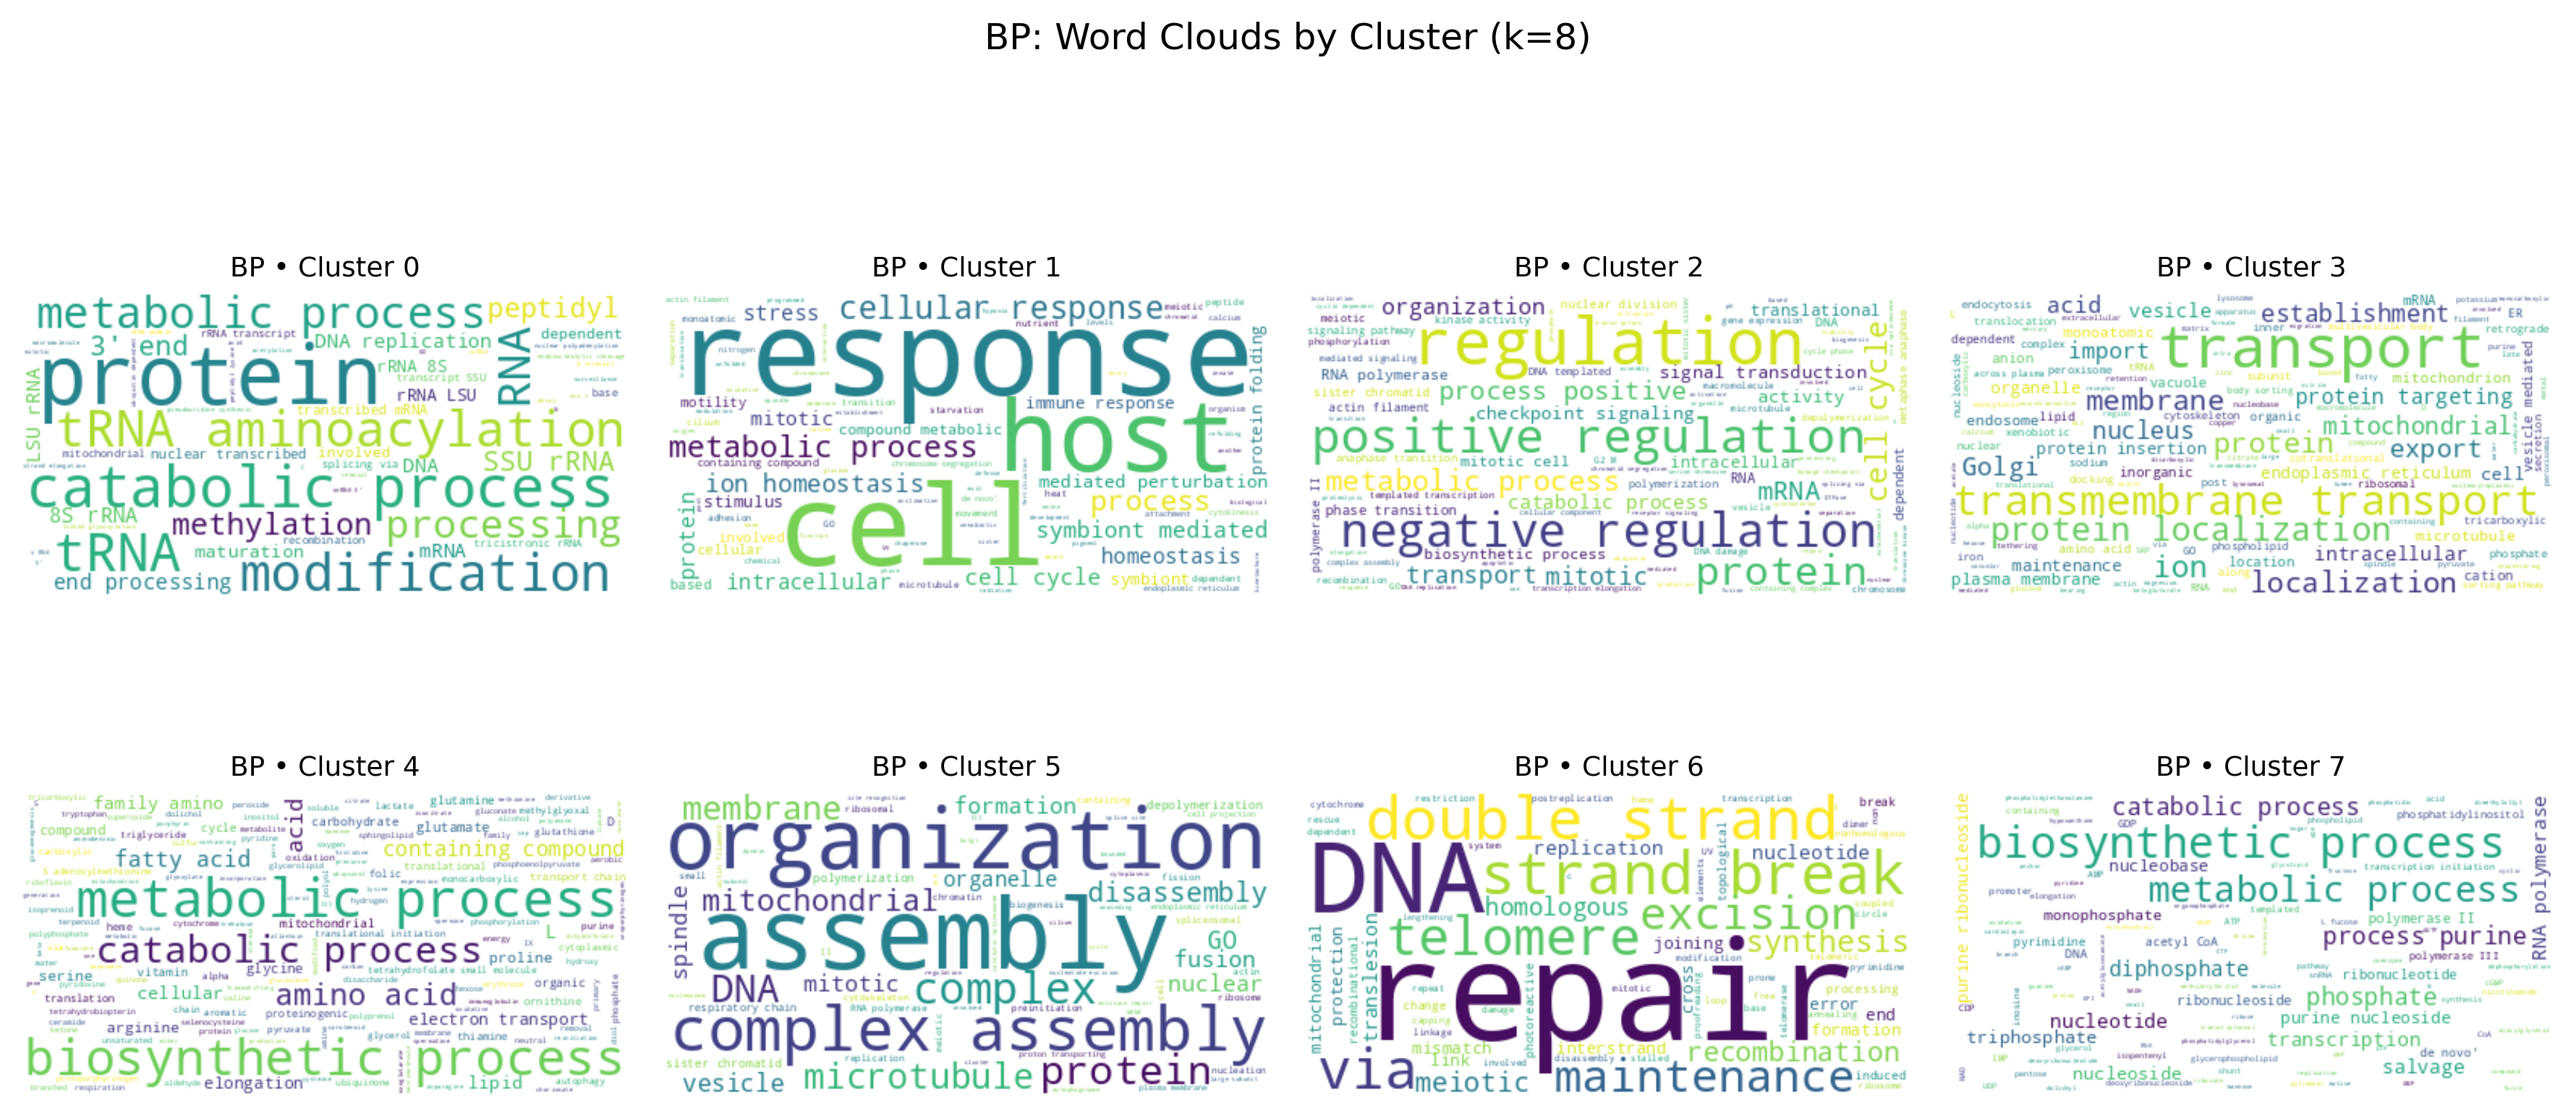

MF: Using overridden k = 7


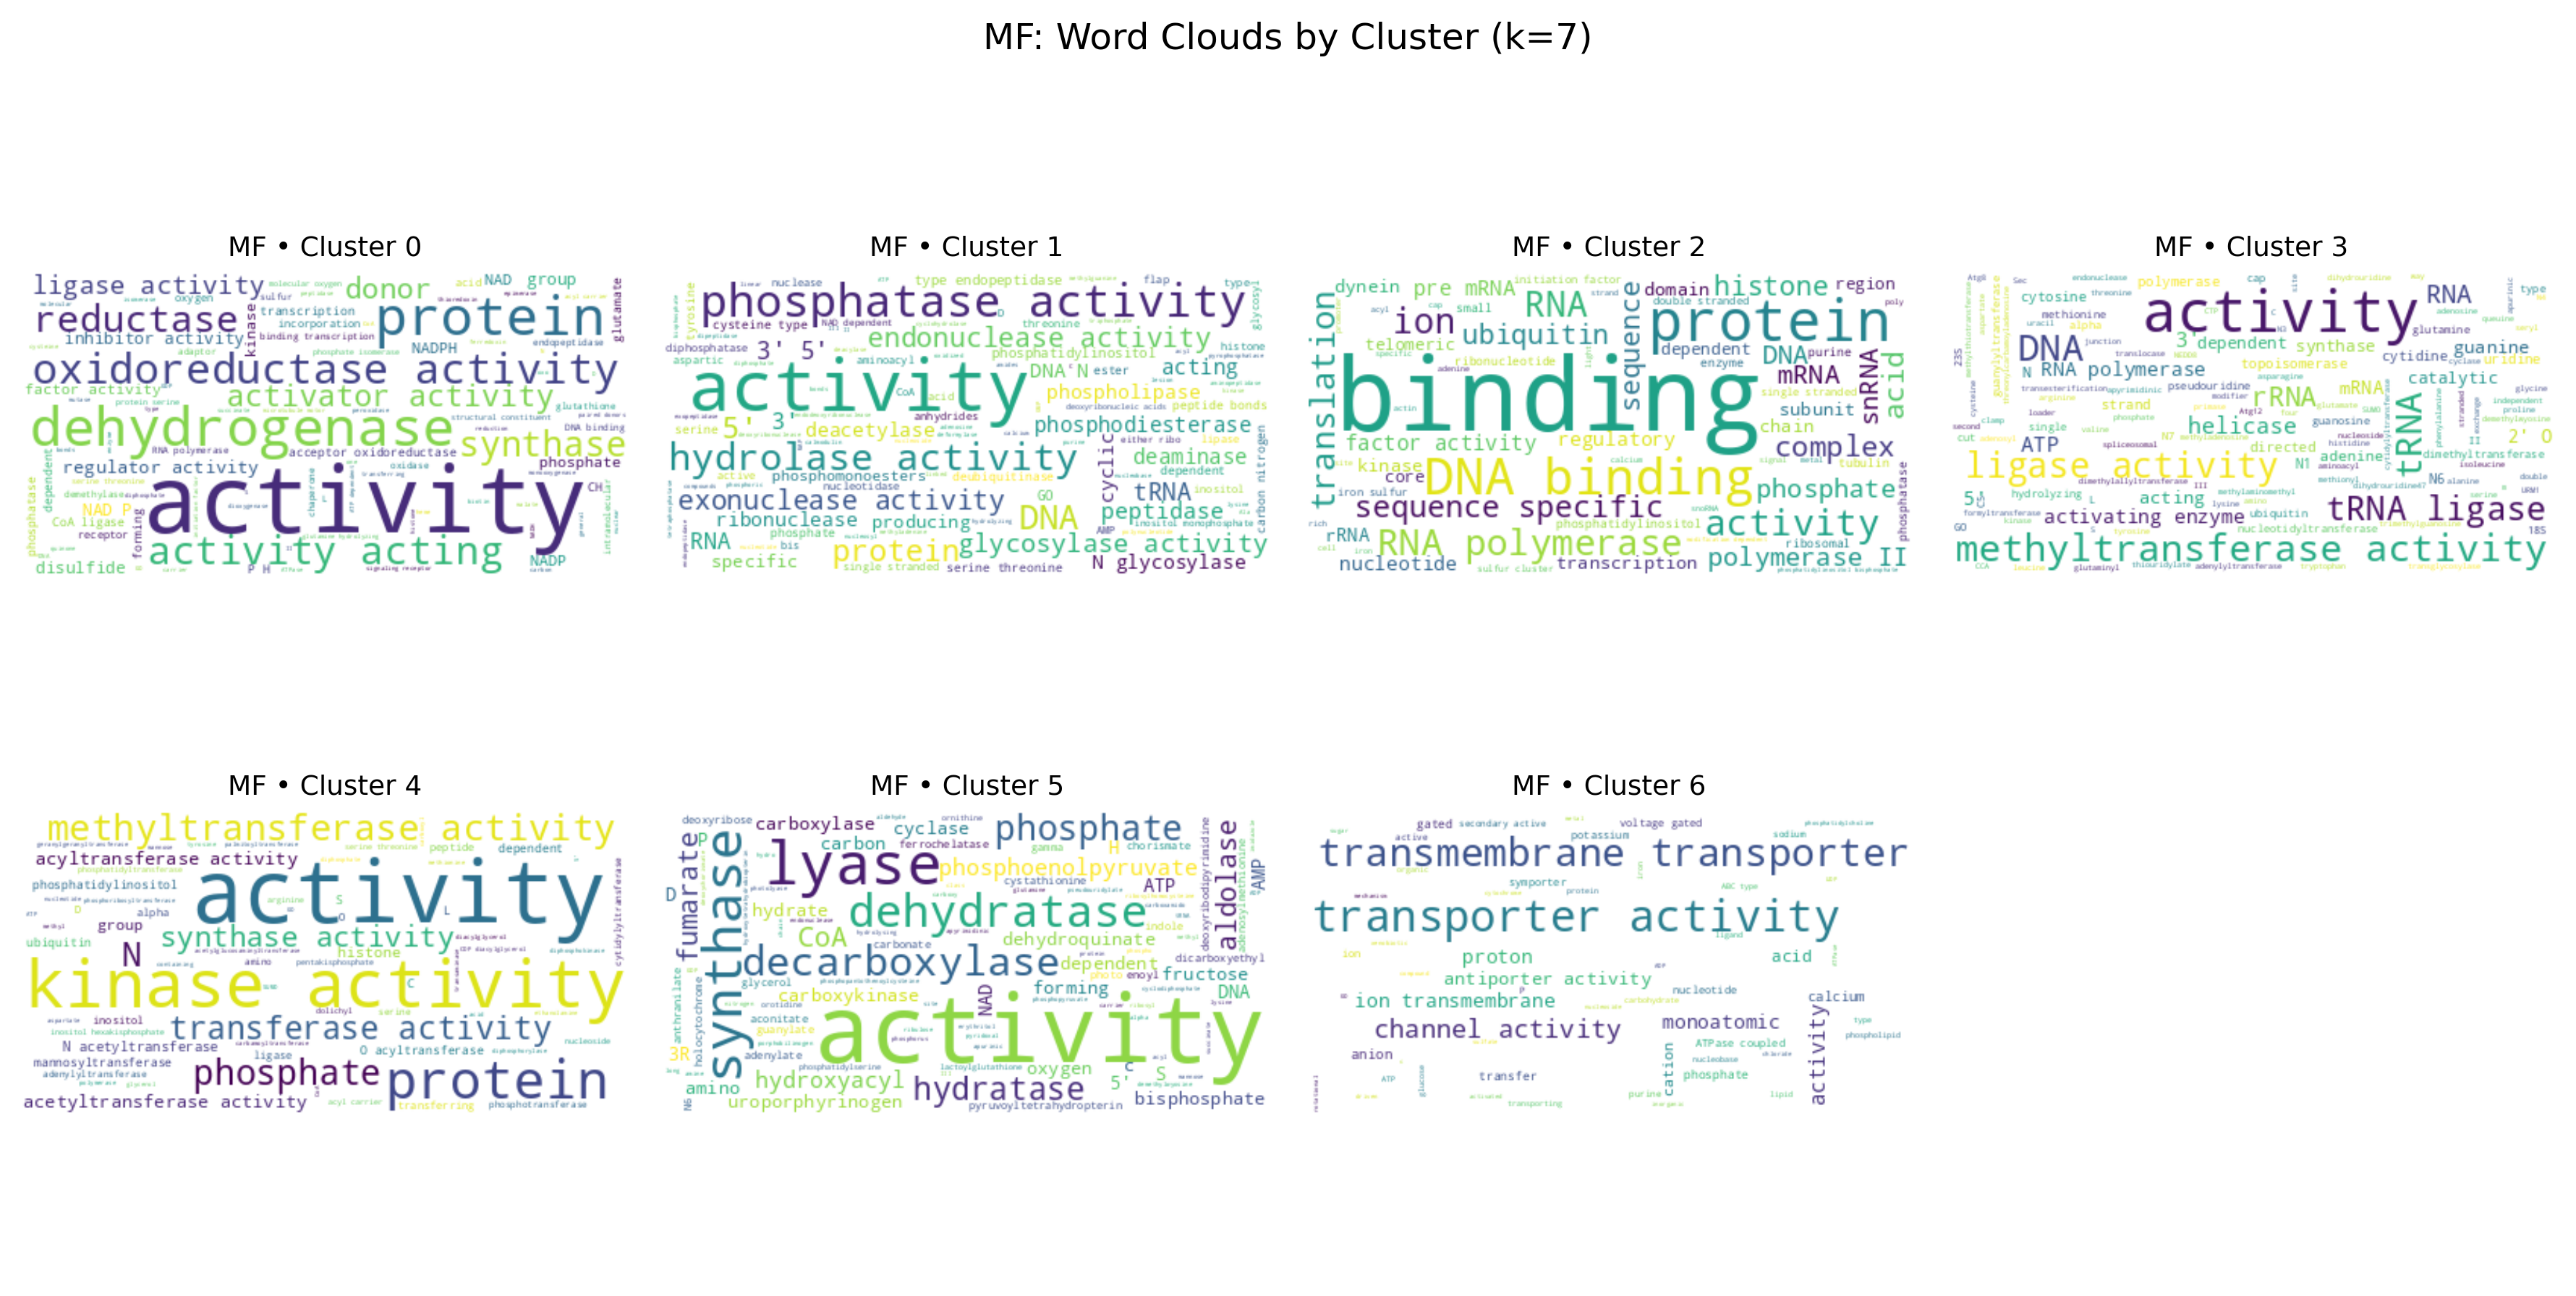

CC: Using overridden k = 4


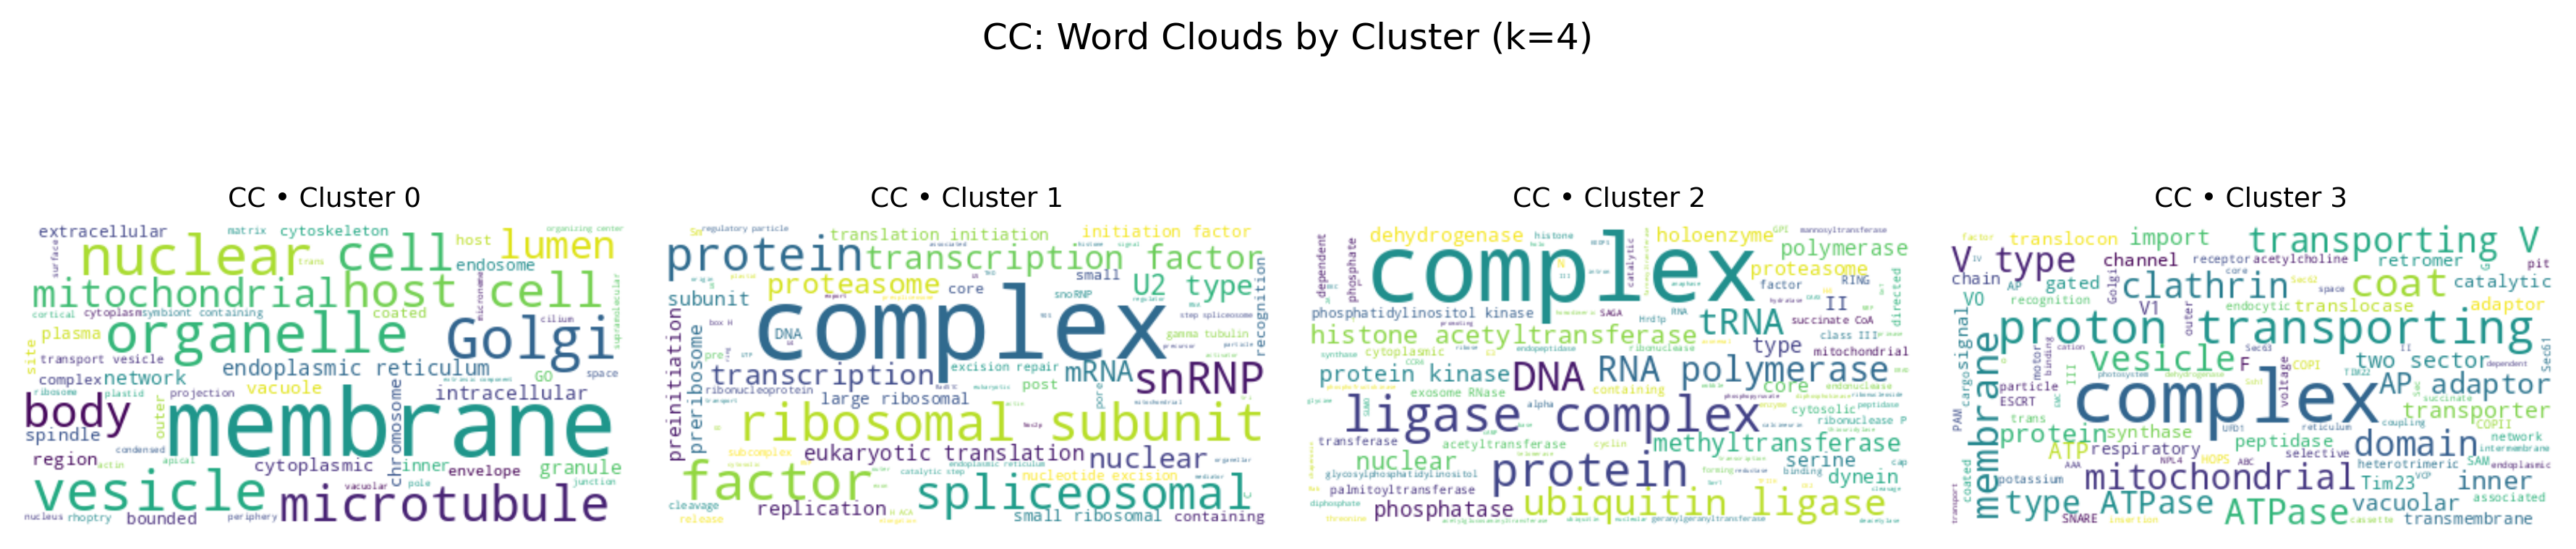

In [ ]:
def cluster_and_wordcloud_grid(
    sim_matrices,
    obo_file="go-basic.obo",
    k_min=2,
    k_max=10,
    k_overrides=None,
    show_silhouette=True,
    wc_width=400,
    wc_height=200,
    ncols=4,                # grid columns for wordclouds
    dpi=300,                # figure DPI (you asked for 300)
    save_png=False,         # set True to save each ontology's grid
    out_prefix="wordclouds" # filename prefix if saving
):
    """
    Clusters each ontology and shows a single grid figure of word clouds per ontology.

    k_overrides: dict like {'CC': 5} to force specific k for some ontologies.
    """

    k_overrides = k_overrides or {}

    term_names = {}
    with open(obo_file) as f:
        current_id = None
        for raw in f:
            line = raw.strip()
            if line == "[Term]":
                current_id = None
            elif line.startswith("id: GO:"):
                current_id = line.split("id: ", 1)[1]
            elif line.startswith("name: ") and current_id:
                term_names[current_id] = line.split("name: ", 1)[1]

    for onto, sim in sim_matrices.items():
        terms = sim.index.tolist()
        X = sim.values

        if onto in k_overrides:
            best_k = int(k_overrides[onto])
            sil_scores = None
            print(f"{onto}: Using overridden k = {best_k}")
        else:
            ks = list(range(k_min, k_max + 1))
            sil_scores = []
            for k in ks:
                labels = KMeans(n_clusters=k, random_state=42, n_init="auto").fit_predict(X)
                sil_scores.append(silhouette_score(X, labels))
            best_k = ks[int(np.argmax(sil_scores))]
            print(f"{onto}: Optimal k = {best_k}")

            if show_silhouette:
                plt.figure(figsize=(3, 3), dpi=dpi)
                plt.plot(ks, sil_scores, marker='o')
                plt.title(f"{onto} Silhouette Scores")
                plt.xlabel("k")
                plt.ylabel("Silhouette")
                plt.tight_layout()
                plt.show()

        final_labels = KMeans(n_clusters=best_k, random_state=42, n_init="auto").fit_predict(X)
        df = pd.DataFrame({'GO_ID': terms, 'Cluster': final_labels})
        df.to_csv(f'{onto}_term_clusters.tsv', sep='\t', index=False)

        cluster_ids = sorted(set(final_labels))

        cluster_texts = []
        for cid in cluster_ids:
            cluster_terms = df[df['Cluster'] == cid]['GO_ID']
            names = [term_names.get(t, "") for t in cluster_terms]

            names = [n if n else t for n, t in zip(names, cluster_terms)]
            cluster_texts.append((" ".join(names)).strip() or "NA")

        cols = min(ncols, len(cluster_ids))
        rows = math.ceil(len(cluster_ids) / cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3), dpi=dpi)
        if rows == 1 and cols == 1:
            axes = np.array([[axes]])
        elif rows == 1:
            axes = np.array([axes])
        elif cols == 1:
            axes = np.array([[ax] for ax in axes])

        for idx, (cid, text) in enumerate(zip(cluster_ids, cluster_texts)):
            r, c = divmod(idx, cols)
            ax = axes[r, c]
            wc = WordCloud(width=wc_width, height=wc_height, background_color='white').generate(text)
            ax.imshow(wc, interpolation='bilinear')
            ax.axis('off')
            ax.set_title(f"{onto} • Cluster {cid}", fontsize=9)

        for idx in range(len(cluster_ids), rows*cols):
            r, c = divmod(idx, cols)
            axes[r, c].axis('off')

        fig.suptitle(f"{onto}: Word Clouds by Cluster (k={best_k})", fontsize=12, y=0.99)
        plt.tight_layout()
        if save_png:
            fig.savefig(f"{out_prefix}_{onto}_k{best_k}.png", bbox_inches="tight", dpi=dpi)
        plt.show()
cluster_and_wordcloud_grid(
    sim_matrices,
    obo_file="go-basic.obo",
    k_min=2, k_max=10,
    k_overrides={'CC': 4, 'MF': 7, 'BP': 8},
    ncols=4,      # grid columns
    dpi=300,      # high-res
    save_png=True # save each ontology’s grid as a PNG
)

In [ ]:
cluster_labels = {
    'BP': {
        0: 'RNA Processing & Modification',
        1: 'Cellular & Host Stress Response',
        2: 'Regulation of Biological Processes',
        3: 'Protein Transport & Localization',
        4: 'Amino Acid & Fatty Acid Metabolism',
        5: 'Macromolecular Complex Assembly & Organization',
        6: 'DNA Damage Response & Repair',
        7: 'Nucleotide Metabolism & Biosynthesis',
    },
    'MF': {
        0: 'Redox Activity',
        1: 'Hydrolases & Phosphatases',
        2: 'DNA/RNA Binding & Polymerase Activity',
        3: 'RNA Processing',
        4: 'Kinases & Transferases',
        5: 'Lyase & Synthase Enzymes',
        6: 'Transporter & Channel Activity',
    },
    'CC': {
        0: 'Membrane & Organelle',
        1: 'Gene-Expression Complexes',
        2: 'Nuclear Enzyme Complexes',
        3: 'Membrane Transport & Vesicle',
        4: 'Nuclear Enzyme Complexes',
    }

}

In [ ]:
df_BP = pd.read_csv('BP_term_clusters.tsv', sep='\t')
df_MF = pd.read_csv('MF_term_clusters.tsv', sep='\t')
df_CC = pd.read_csv('CC_term_clusters.tsv', sep='\t')

cluster_dfs = {
    'BP': df_BP,
    'MF': df_MF,
    'CC': df_CC
}


labeled = {}
for onto, df in cluster_dfs.items():
    df2 = df.rename(columns={'Cluster':'ClusterID'}).copy()
    df2['ClusterName'] = df2['ClusterID'].map(cluster_labels[onto])

    df2 = df2[['GO_ID', 'ClusterID', 'ClusterName']]
    labeled[onto] = df2

master = (
    pd.concat(labeled, names=['Ontology'])
      .reset_index(level=0)
      .reset_index(drop=True)
)


# 5) Save or display
labeled['BP'].to_csv('BP_term_clusters.tsv', sep='\t', index=False)
labeled['MF'].to_csv('MF_term_clusters.tsv', sep='\t', index=False)
labeled['CC'].to_csv('CC_term_clusters.tsv', sep='\t', index=False)
master.to_csv('all_ontologies_term_clusters.tsv', sep='\t', index=False)
